In [6]:
# Imports

# General imports
import os
import tables as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# Brian with units and wrapped numpy
import brian2 as br
from brian2 import um, mm, cm, meter
from brian2 import mV, ms, second, ohm, siemens, msiemens, farad, ufarad
from brian2 import np

# Scripts from publication: pyoelectricity
import pyoelectricity as pel

# Used for development
# import importlib
# importlib.reload(pel)

In [7]:
data_path = Path("simulation/purkinje/")
result_file_names = sorted([f for f in os.listdir(data_path) if 'otm' in f])
result_file_names = sorted([f for f in os.listdir(data_path)])
result_file_names

['1um_2k--hh.h5',
 '1um_2k--rtm-0.25.h5',
 '1um_2k--rtm-0.50.h5',
 '1um_2k--rtm-1.00.h5',
 '1um_2k--tm.h5',
 '1um_2k-ohh.h5',
 '1um_2k-ortm-0.25.h5',
 '1um_2k-ortm-0.50.h5',
 '1um_2k-ortm-1.00.h5',
 '1um_2k-otm.h5']

In [105]:
#result_file_names=  ['1um_500-otm.h5', '1um_5k-otm.h5']

# Morphology

In [3]:
def plot_morpho(result):
    fig, ax = plt.subplots(1, 1, figsize=(16,2))
    ax.axis('equal')

    source_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(
        result['source_x']/um, result['source_y']/um, result['source_d']/um)]
    ax.add_collection(mpl.collections.PatchCollection(source_patchs, color='red', label="Source"))    

    target_patchs = [plt.Circle((x, y), d/2.0) for x, y, d in zip(
        result['target_x']/um, result['target_y']/um, result['target_d']/um)]
    u = mpl.collections.PatchCollection(target_patchs, color='green', label='Target')
    ax.add_collection(u)    

    ax.set_ylim(-3, 3)
    ax.set_xlim(1000-30, 1000+30)
    ax.set_xlabel('x/um')
    ax.set_ylabel('y/um')
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='red', markersize=10, label='Source'),
                       mpl.lines.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor='green', markersize=10, label='Target')]
    ax.legend(handles=legend_elements, ncol=2)

In [4]:
def check_morpho(result_file_1):
    result = pel.get_result(result_file_1, downsampling_factor=1e4)
    print(f'{result_file_1.name:14s}|{"Source min":16s}|{"Source max":16s}|{"Target min":16s}|{"Target max":16s}')
    print((16*5+4)*'-')
    def print_lims(quant):
        print(f'{quant:4s} {str(result["source_"+quant].shape):>12s} | '
              +f'{result["source_"+quant].min().in_best_unit(3):>14s} | '
              +f'{result["source_"+quant].max().in_best_unit(3):>14s} | '
              +f'{result["target_"+quant].min().in_best_unit(3):>14s} | '
              +f'{result["target_"+quant].max().in_best_unit(3):>14s}'
             )
    print_lims('x')
    print_lims('y')
    print_lims('d')
    print_lims('v')
    print_lims('t')
    
    plot_morpho(result)
    plt.show()

1um_500-otm.h5|Source min      |Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x          (500,) |          1. um |       0.999 mm |       0.501 mm |       1.499 mm
y          (500,) |           0. m |           0. m |          1. um |          1. um
d          (500,) |          1. um |          2. um |          1. um |          1. um
v        (500, 9) |       -100. mV |  -9.631e-91 yV |      -1.556 mV |       0.439 mV
t            (9,) |           0. s |          8. ms |           0. s |          8. ms


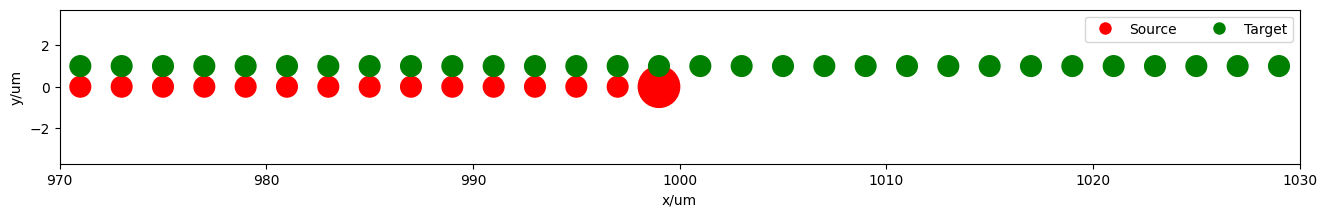

1um_500_g1200-otm.h5|Source min      |Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x          (500,) |          1. um |       0.999 mm |       0.501 mm |       1.499 mm
y          (500,) |           0. m |           0. m |          1. um |          1. um
d          (500,) |          1. um |          2. um |          1. um |          1. um
v        (500, 9) |       -100. mV |         -0. YV |     -46.668 uV |       19.95 uV
t            (9,) |           0. s |          8. ms |           0. s |          8. ms


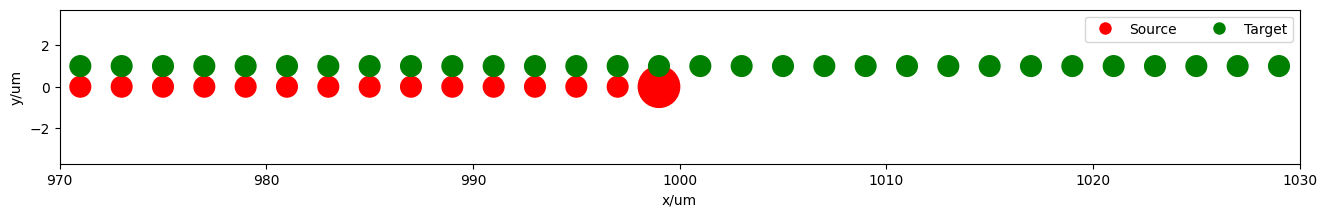

1um_2k_g1200-otm.h5|Source min      |Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x         (2000,) |        250. nm |          1. mm |         0.5 mm |         1.5 mm
y         (2000,) |           0. m |           0. m |          1. um |          1. um
d         (2000,) |          1. um |          2. um |          1. um |          1. um
v       (2000, 9) |       -100. mV |         -0. YV |     -43.176 uV |      18.493 uV
t            (9,) |           0. s |          8. ms |           0. s |          8. ms


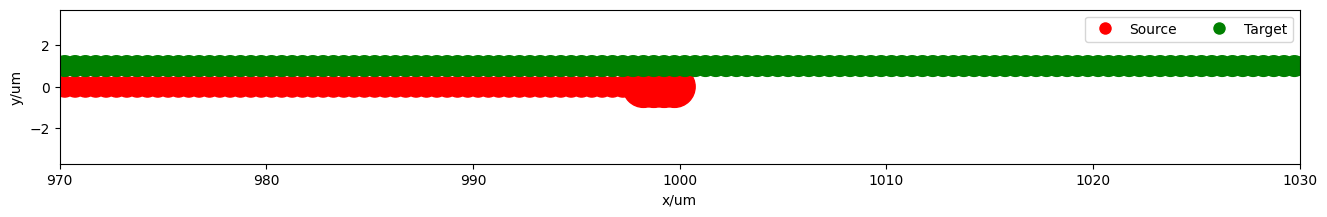

1um_5k-otm.h5 |Source min      |Source max      |Target min      |Target max      
------------------------------------------------------------------------------------
x         (5000,) |        100. nm |          1. mm |         0.5 mm |         1.5 mm
y         (5000,) |           0. m |           0. m |          1. um |          1. um
d         (5000,) |          1. um |          2. um |          1. um |          1. um
v       (5000, 9) |       -100. mV |  -7.264e-91 yV |      -1.554 mV |       0.433 mV
t            (9,) |           0. s |          8. ms |           0. s |          8. ms


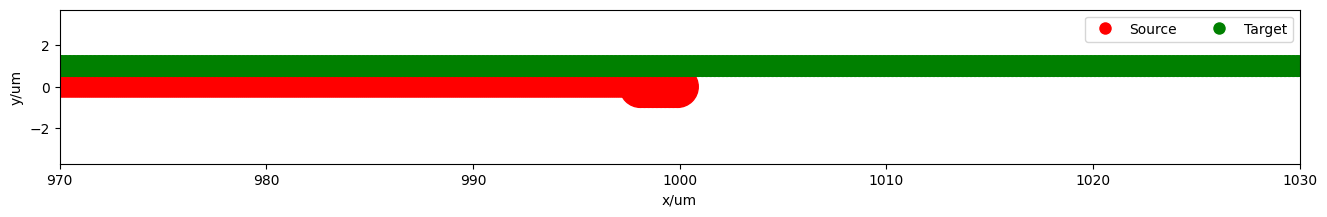

In [108]:
for filename in result_file_names:
    check_morpho(Path(data_path, filename))

# Source AP & V_ext & Impact Overview

['1um-otm']          Simulation:  0.69m/s,  0.030mm
Prop peak: 2.5mV : scaling factor = 0.44 | Target max: 2.3mV (scaled 1.01) | Target min: -4.5mV (scaled -1.99)
['1um_2k-otm']       Simulation:  0.74m/s,  0.022mm
Prop peak: 1.1mV : scaling factor = 0.99 | Target max: 1.0mV (scaled 1.03) | Target min: -3.2mV (scaled -3.16)
['1um_2k_g1200-otm'] Simulation:  1.20m/s,  0.014mm
Prop peak: 2.4mV : scaling factor = 0.46 | Target max: 2.2mV (scaled 1.00) | Target min: -6.5mV (scaled -2.98)
['1um_500-otm']      Simulation:  0.73m/s,  0.022mm
Prop peak: 1.1mV : scaling factor = 0.96 | Target max: 1.1mV (scaled 1.07) | Target min: -3.4mV (scaled -3.31)
['1um_500_g1200-otm'] Simulation:  1.18m/s,  0.014mm
Prop peak: 2.5mV : scaling factor = 0.44 | Target max: 2.3mV (scaled 1.03) | Target min: -7.1mV (scaled -3.11)
['1um_5k-otm']       Simulation:  0.74m/s,  0.024mm
Prop peak: 1.1mV : scaling factor = 0.99 | Target max: 1.0mV (scaled 1.03) | Target min: -3.2mV (scaled -3.17)


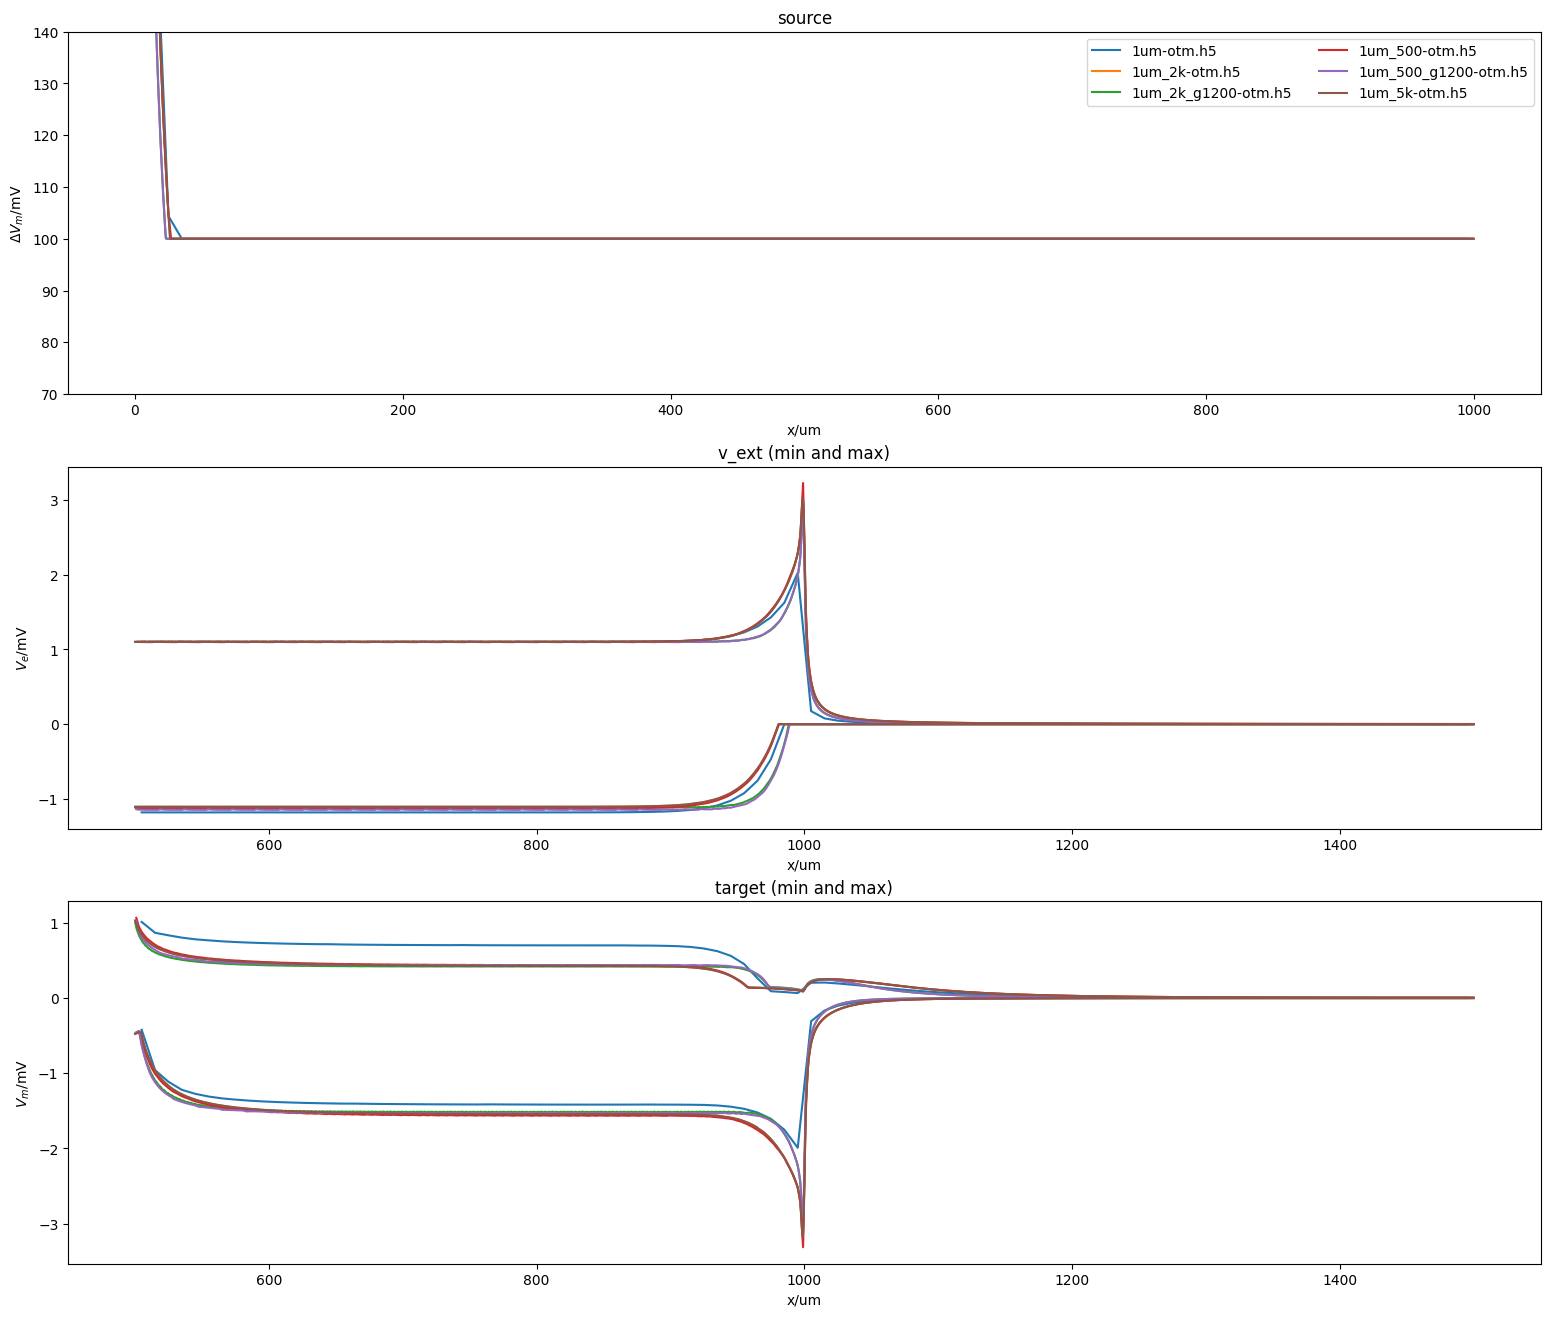

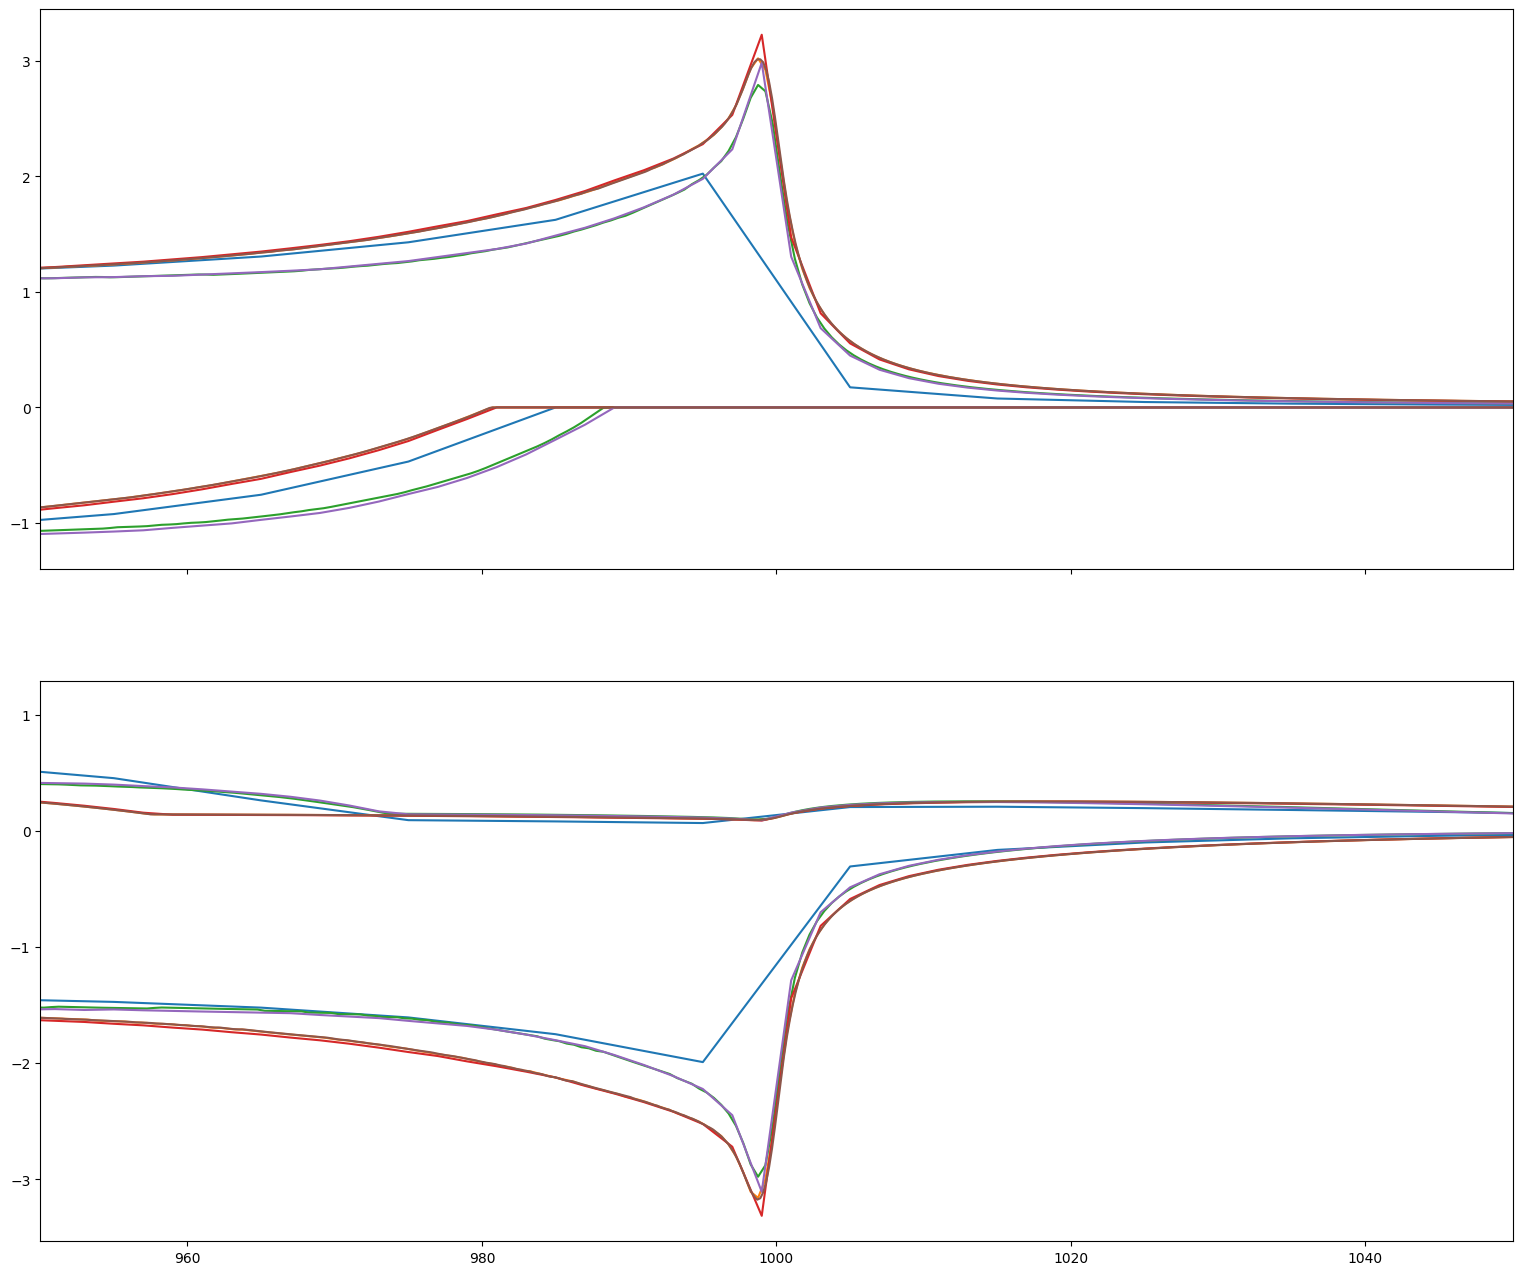

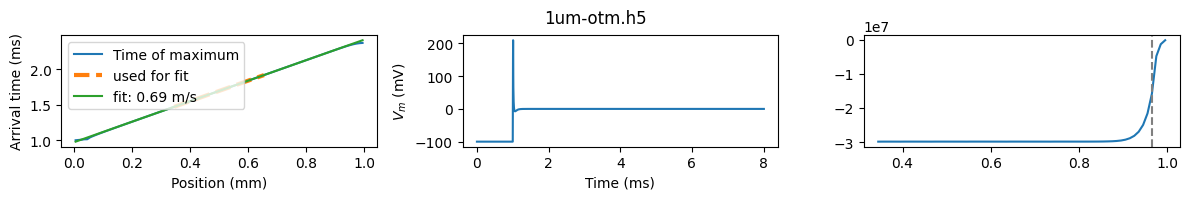

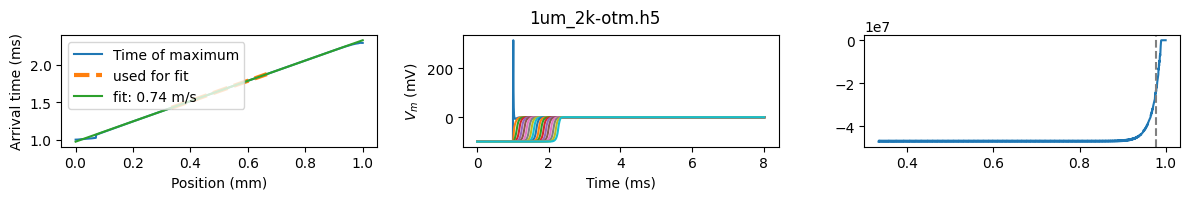

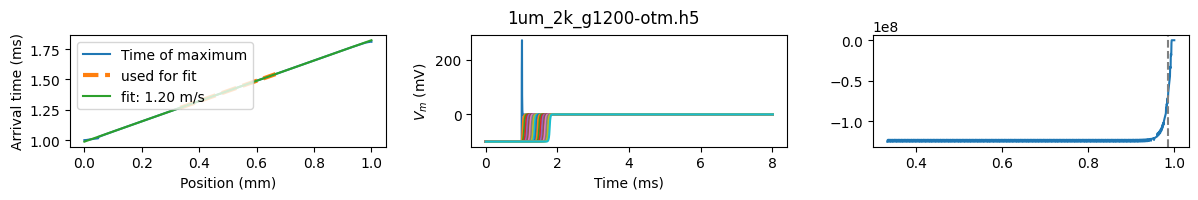

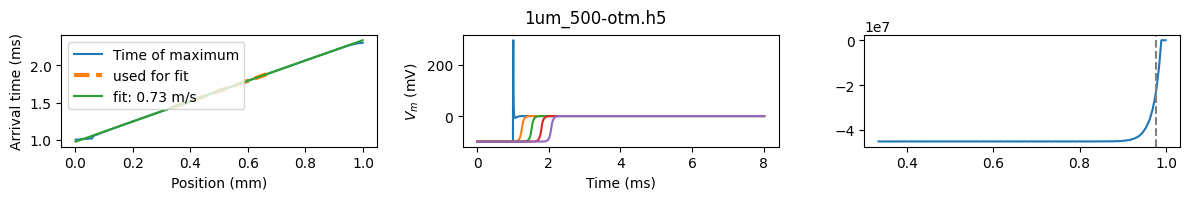

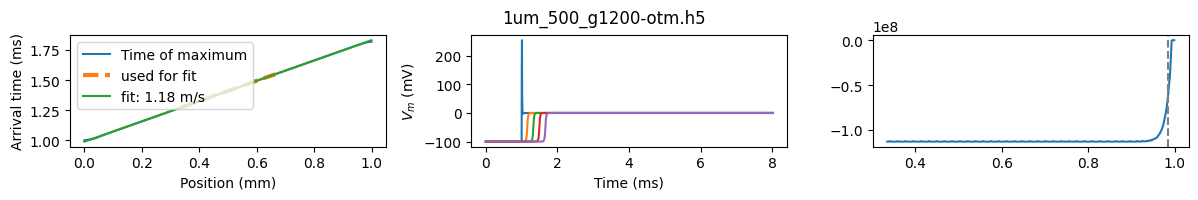

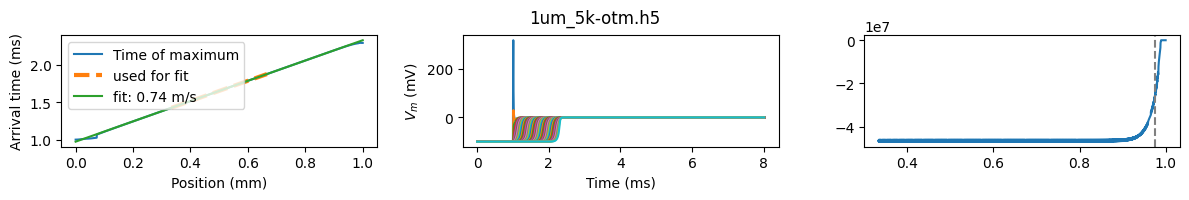

In [117]:
# test
fig, axs = plt.subplots(3, 1, figsize=(19, 16))
fig, axsZ = plt.subplots(2, 1, figsize=(19, 16), sharex=True)
for result_file in result_file_names:
    result = pel.get_result(Path(data_path, result_file))
    print('%-20s'%result_file.split('.')[:-1], end=' ')
    
    # Calculate v and lambda_star from simulation
    v_p, lambda_star = pel.get_velocity(M=None,
                           make_plots=True,
                           is_collision=False,
                           time_m=result['source_t'],
                           x_m=result['source_x'],
                           v_m=result['source_v'],
                           figsize=(12,2)
                          )
    plt.tight_layout()
    plt.suptitle(result_file);
    
    label = result_file
    axs[0].plot(result['source_x']/um,
                (result['source_v'].max(1)-result['source_v'].min(1))/mV,
                label=label)
    
    vext_max = result['v_ext_v'].max(1)
    prop_peak = vext_max[0]
    if True: #Normalize
        scaling_f = 1.1*mV/prop_peak
        print(f'Prop peak: {prop_peak/mV:2.1f}mV : scaling factor = {scaling_f:1.2f}', end=' | ')
        targ_max_mV = np.max(result['target_v'].max(1)/mV)
        print(f'Target max: {targ_max_mV:2.1f}mV (scaled {targ_max_mV*scaling_f:1.2f})', end=' | ')
        targ_min_mV = np.min(result['target_v'].min(1)/mV)
        print(f'Target min: {targ_min_mV:2.1f}mV (scaled {targ_min_mV*scaling_f:1.2f})')
    else:
        scaling_f = 1#*mV/prop_peak

    # External V_ext
    for ax in [axsZ[0], axs[1]]:
        ln = ax.plot(result['target_x']/um,
                     vext_max/mV*scaling_f,
                     label=label)
        ax.plot(result['target_x']/um,
                    result['v_ext_v'].min(1)/mV*scaling_f,
                    label=label,
                    color=ln[0].get_color())
    # Target V_m
    axs[2].set_title('target (min and max)')
    axs[2].set_ylabel('$V_m$/mV')
    axs[2].set_xlabel('x/um')
    for ax in [axsZ[1], axs[2]]:
        ln = ax.plot(result['target_x']/um,
                         result['target_v'].max(1)/mV*scaling_f,
                         label=label)
        ax.plot(result['target_x']/um,
                    result['target_v'].min(1)/mV*scaling_f,
                    label=label,
                    color=ln[0].get_color())


# Source
axs[0].set_title('source')
axs[0].set_ylabel('$\Delta V_m$/mV')
axs[0].set_xlabel('x/um')
axs[0].set_ylim(70, 140)
axs[0].legend(loc='best', ncol=2)

# v_ext
axs[1].set_title('v_ext (min and max)')
axs[1].set_ylabel('$V_e$/mV')
axs[1].set_xlabel('x/um')

axsZ[0].set_xlim(1000-50, 1000+50)
#plt.tight_layout()
plt.show()
plt.close('all');

In [124]:
np.sqrt(1200/450)

1.632993161855452

# Source AP & V_ext & Impact Overview g1200

In [5]:
data_path = Path("/media/ms/SSDData/ephys-simulation/purkinje/")
result_file_names = sorted([f for f in os.listdir(data_path) if '-tm.h5' in f])
result_file_names

['1um--tm.h5',
 '1um_2k_g1200--tm.h5',
 '1um_500--tm.h5',
 '1um_500_g1200--tm.h5',
 '1um_5k--tm.h5']

['1um--tm']          Simulation:  0.69m/s,  0.030mm
['1um_2k_g1200--tm'] Simulation:  1.20m/s,  0.016mm
['1um_500--tm']      Simulation:  0.73m/s,  0.024mm
['1um_500_g1200--tm'] Simulation:  1.18m/s,  0.016mm
['1um_5k--tm']       Simulation:  0.74m/s,  0.025mm


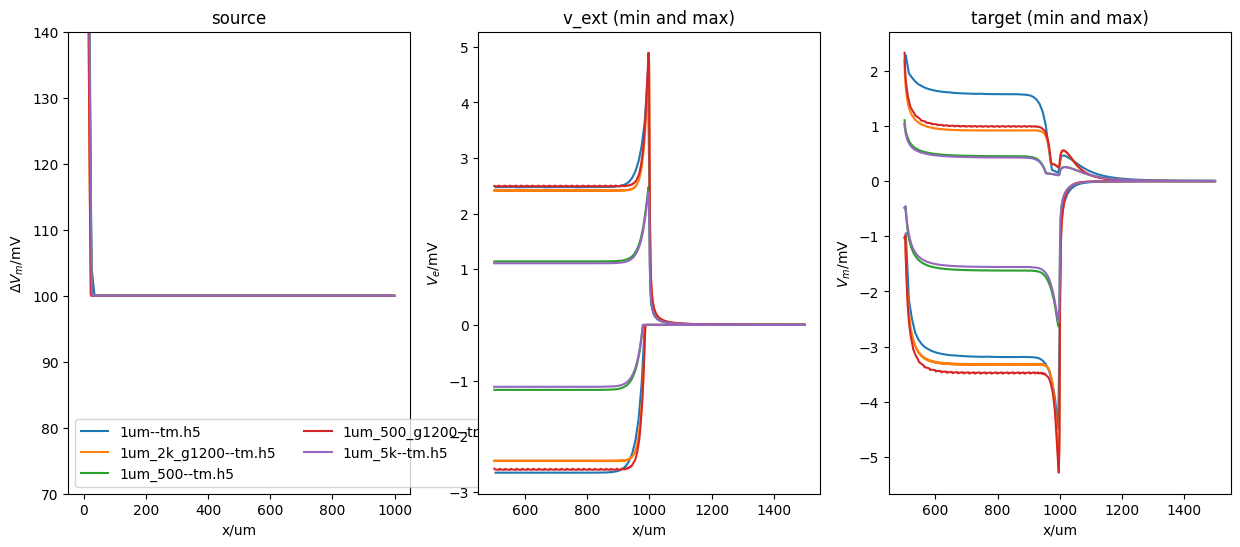

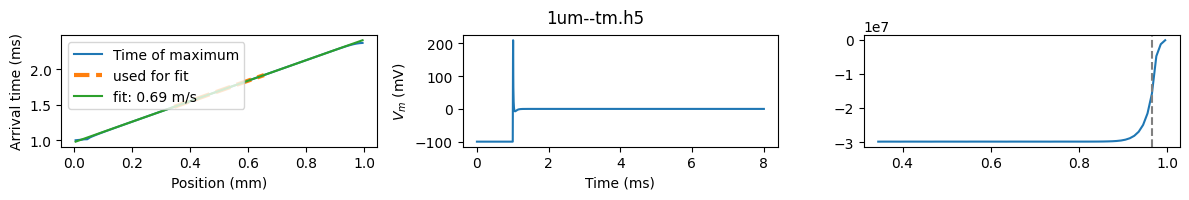

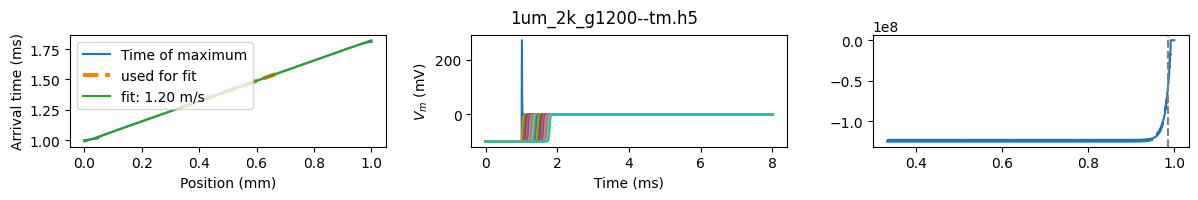

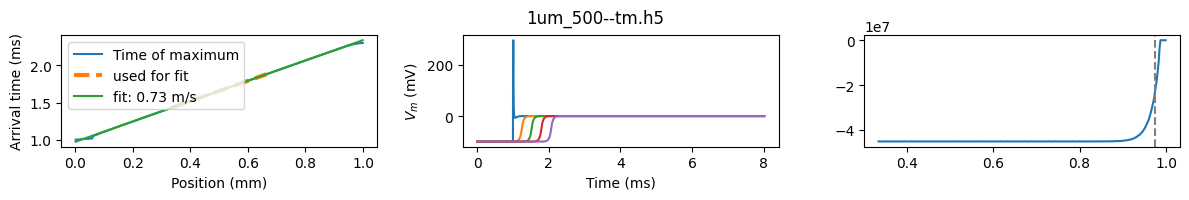

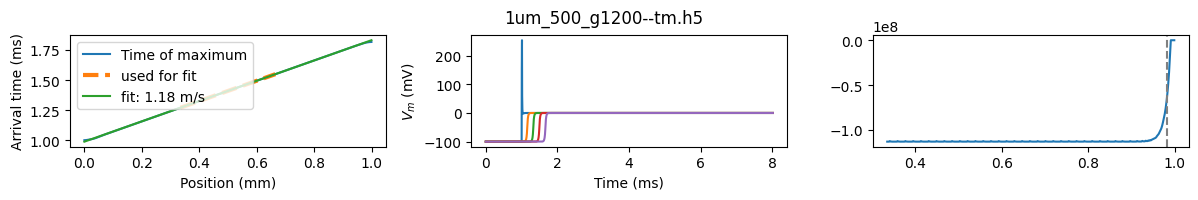

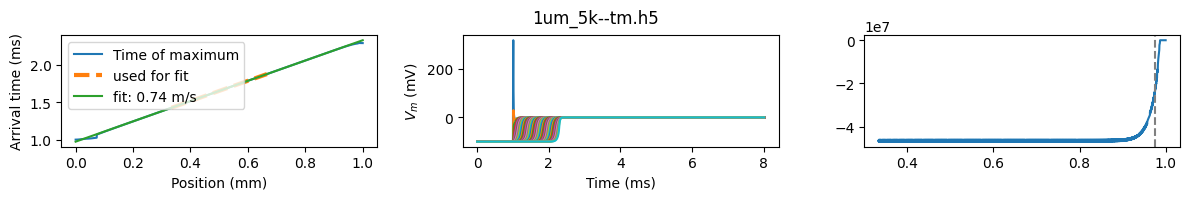

In [7]:
# test
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

for result_file in result_file_names:
    result = pel.get_result(Path(data_path, result_file), downsampling_factor=1)
    print('%-20s'%result_file.split('.')[:-1], end=' ')
    
    # Calculate v and lambda_star from simulation
    v_p, lambda_star = pel.get_velocity(M=None,
                           make_plots=True,
                           is_collision=False,
                           time_m=result['source_t'],
                           x_m=result['source_x'],
                           v_m=result['source_v'],
                           figsize=(12,2)
                          )
    plt.tight_layout()
    plt.suptitle(result_file);
    
    label = result_file
    axs[0].plot(result['source_x']/um,
                (result['source_v'].max(1)-result['source_v'].min(1))/mV,
                label=label)
    
    vext_max = result['v_ext_v'].max(1)
    prop_peak = vext_max[0]
    if False: #Normalize
        scaling_f = 1.1*mV/prop_peak
        print(result['source_params'])
        print(f'{label:20s}: scaling factor = {scaling_f:1.2f}')
    else:
        scaling_f = 1#*mV/prop_peak

    ln = axs[1].plot(result['target_x']/um,
                 vext_max/mV*scaling_f,
                 label=label)
    axs[1].plot(result['target_x']/um,
                result['v_ext_v'].min(1)/mV*scaling_f,
                label=label,
                color=ln[0].get_color())
    # Target
    axs[2].set_title('target (min and max)')
    axs[2].set_ylabel('$V_m$/mV')
    axs[2].set_xlabel('x/um')
    ln = axs[2].plot(result['target_x']/um,
                     result['target_v'].max(1)/mV*scaling_f,
                     label=label)
    axs[2].plot(result['target_x']/um,
                result['target_v'].min(1)/mV*scaling_f,
                label=label,
                color=ln[0].get_color())
    
    #break


# Source
axs[0].set_title('source')
axs[0].set_ylabel('$\Delta V_m$/mV')
axs[0].set_xlabel('x/um')
axs[0].set_ylim(70, 140)
axs[0].legend(loc='best', ncol=2)

# v_ext
axs[1].set_title('v_ext (min and max)')
axs[1].set_ylabel('$V_e$/mV')
axs[1].set_xlabel('x/um')

#plt.tight_layout()
plt.show()
plt.close('all');

# Final Plot

## Low res (N=500)

500-o
HH        : prop_peak = -0.42379157 mV
TM        : prop_peak = -1.16660006 mV
$0.25$ ms : prop_peak = -1.1990474 mV
$0.5$ ms  : prop_peak = -1.17962854 mV
$1$ ms    : prop_peak = -1.18014726 mV


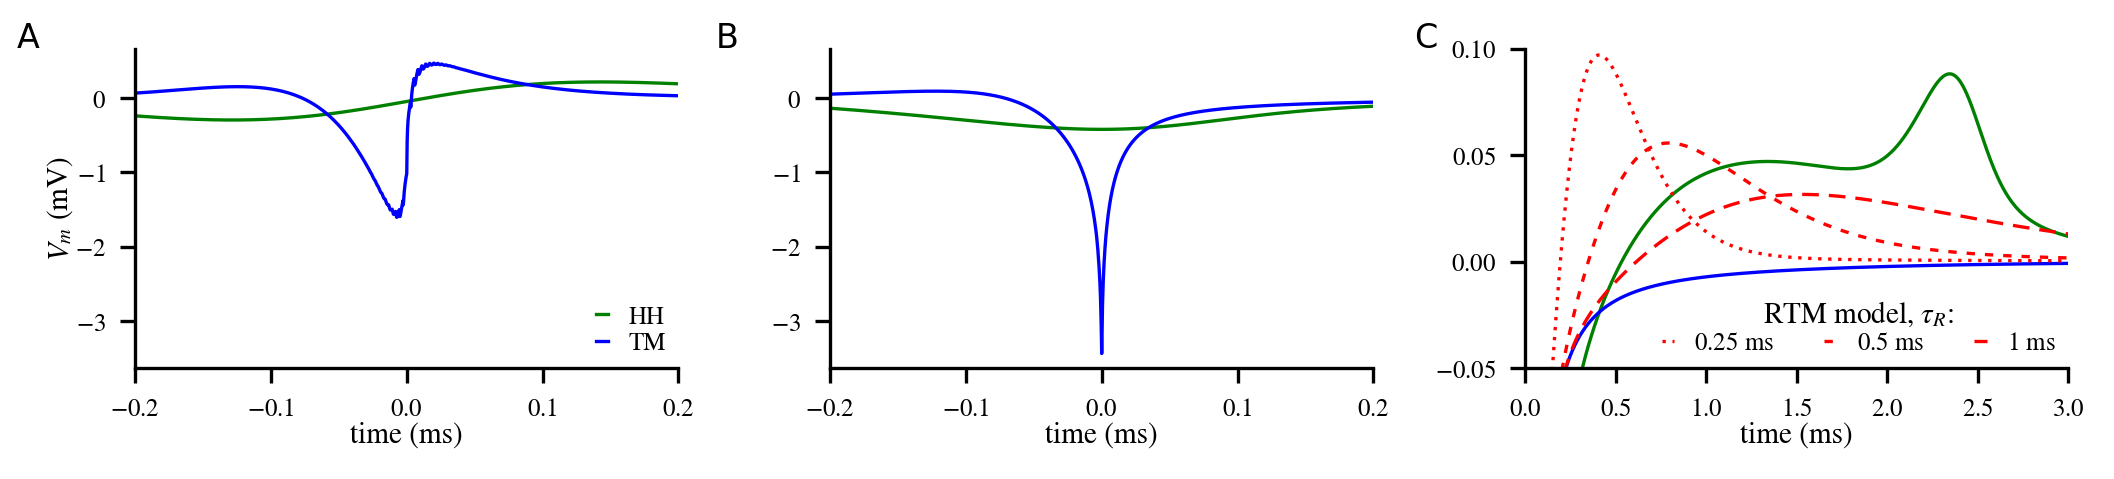

In [136]:
# Create figure
case = '500--'
cases = ['500--', '500-o', '5k--', '5k-o']
cases = ['500-o']

for case in cases:
    print(case)
    with plt.style.context('plot_style.txt'):
        cm = 1/2.54 # 11.4 or 17.8
        fig, axs = plt.subplots(1,3, sharey=False, figsize=(17.8*cm,4*cm))#, gridspec_kw={'width_ratios':(2,3)})

        def plt_purkinje(result_file, scale=False, **kwargs):
            result = pel.get_result(Path(data_path, result_file), downsampling_factor=1)

            vext_max = result['v_ext_v'].min(1)
            prop_peak = vext_max[0]#len(vext_max)//4]
            print(f'{kwargs["label"]:10s}: prop_peak = {prop_peak}')
            scaling_f = -1.1*mV/prop_peak

            source_n = result['source_v'].shape[0]
            ix_min = result['target_v'].min(1).argmin()

            t, v = result['target_t'], result['target_v']#*scaling_f
            if scale:
                v = v*scaling_f
                print(f'{kwargs["label"]:10s}: scaling factor = {scaling_f:1.2f}')
            # Plot target impact by propagaging AP
            v_propagating = v[ix_min//3,:]
            t_0_propagating = t[v_propagating.argmin()]
            t_0_propagating = t[np.diff(v_propagating).argmax()]
            # Plot target impact by annihilating AP
            v_annihilating = v[ix_min,:]
            t_0_annihilating = t[v_annihilating.argmin()]
            if 'ms' in kwargs['label']:
                axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
            else:
                axs[0].plot((t-t_0_propagating)/ms, v_propagating/mV, **kwargs)
                axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
                kwargs.pop('label')
                axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)


        #plt_purkinje('1um_500--hh.h5'      , scale=True, color='green', ls='--', label='HH (scaled)')
        plt_purkinje('1um_'+case+'hh.h5'      , color='green', ls='-', label='HH')
        plt_purkinje('1um_'+case+'tm.h5'      , color='blue', ls='-', label='TM') 
        plt_purkinje('1um_'+case+'rtm-0.25.h5', color='red', ls=(0, (1, 2)), label=r'$0.25$ ms')
        plt_purkinje('1um_'+case+'rtm-0.50.h5', color='red', ls=(0, (2.5, 3)), label=r'$0.5$ ms')
        plt_purkinje('1um_'+case+'rtm-1.00.h5', color='red', ls=(0, (5, 3)), label=r'$1$ ms')

        axs[0].set_xlabel('time (ms)')
        axs[0].set_ylabel('$V_m$ (mV)')
        axs[0].set_xlim(-0.2, 0.2)
        axs[0].legend(loc='lower right')

        axs[1].set_xlabel('time (ms)')
        axs[1].sharey(axs[0])
        #axs[1].set_xlim(-1.0, 3)
        axs[1].set_xlim(-0.2, 0.2)

        axs[2].set_xlabel('time (ms)')
        axs[2].set_xlim(0.0,3.0)
        axs[2].set_ylim(-.05, 0.1)
        #axs[2].legend(loc='upper right', title=r'RTM model, $\tau_{R}$:')
        axs[2].legend(loc='best', title=r'RTM model, $\tau_{R}$:', ncol = 3)
        #for ax in axs:
        #    ax.tick_params('both', direction='in')

        plt.tight_layout()
        
        for ax, l in zip(axs, ['A', 'B', 'C']):
            X = ax.get_position().x0 - 0.05
            Y = 0.90 #ax.get_position().y1
            ax.annotate(l, fontsize=8,family = 'sans-serif',# weight = 'bold',
                        xycoords="subfigure fraction", 
                        xy=(X, Y)) 

        #fig.savefig('../gfx/Fig4-ABC.svg', bbox_inches='tight')
        plt.show()


## High res (N=2000)

2k-o
HH        : prop_peak = -0.41745096 mV
$0.25$ ms : prop_peak = -1.14264645 mV
$0.5$ ms  : prop_peak = -1.1261651 mV
$1$ ms    : prop_peak = -1.1234181 mV
TM        : prop_peak = -1.11427901 mV


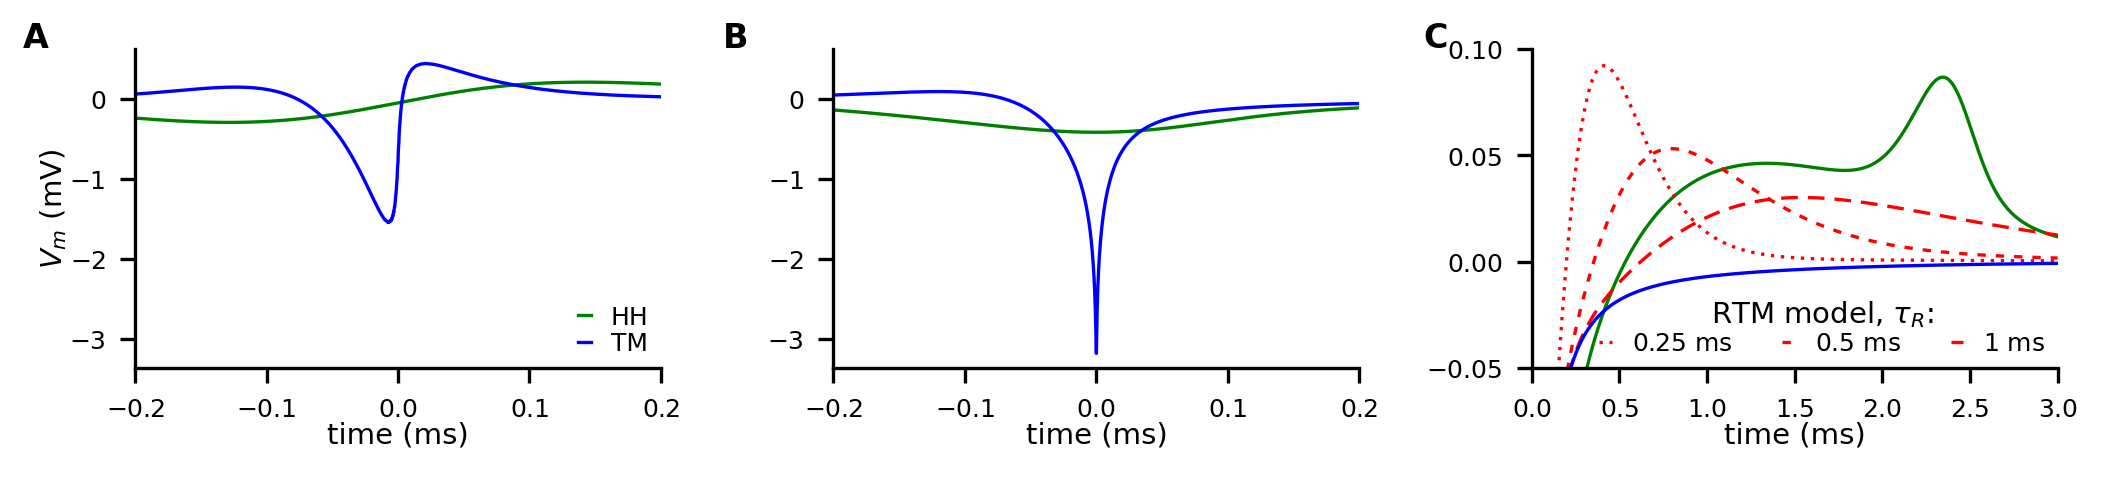

In [6]:
# Create figure
cases = ['2k-o']

for case in cases:
    print(case)
    with plt.style.context('plot_style.txt'):
        cm = 1/2.54 # 11.4 or 17.8
        fig, axs = plt.subplots(1,3, sharey=False, figsize=(17.8*cm,4*cm))#, gridspec_kw={'width_ratios':(2,3)})

        def plt_purkinje(result_file, scale=False, **kwargs):
            result = pel.get_result(Path(data_path, result_file), downsampling_factor=1)

            vext_max = result['v_ext_v'].min(1)
            prop_peak = vext_max[0]#len(vext_max)//4]
            print(f'{kwargs["label"]:10s}: prop_peak = {prop_peak}')
            scaling_f = -1.1*mV/prop_peak

            source_n = result['source_v'].shape[0]
            ix_min = result['target_v'].min(1).argmin()

            t, v = result['target_t'], result['target_v']#*scaling_f
            if scale:
                v = v*scaling_f
                print(f'{kwargs["label"]:10s}: scaling factor = {scaling_f:1.2f}')
            # Plot target impact by propagaging AP
            v_propagating = v[ix_min//3,:]
            t_0_propagating = t[v_propagating.argmin()]
            t_0_propagating = t[np.diff(v_propagating).argmax()]
            # Plot target impact by annihilating AP
            v_annihilating = v[ix_min,:]
            t_0_annihilating = t[v_annihilating.argmin()]
            if 'ms' in kwargs['label']:
                axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
                kwargs.pop('label')
                #axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
            else:
                axs[0].plot((t-t_0_propagating)/ms, v_propagating/mV, **kwargs)
                axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
                kwargs.pop('label')
                axs[2].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)


        #plt_purkinje('1um_500--hh.h5'      , scale=True, color='green', ls='--', label='HH (scaled)')
        plt_purkinje('1um_'+case+'hh.h5'      , color='green', ls='-', label='HH')
        plt_purkinje('1um_'+case+'rtm-0.25.h5', color='red', ls=(0, (1, 2)), label=r'$0.25$ ms')
        plt_purkinje('1um_'+case+'rtm-0.50.h5', color='red', ls=(0, (2.5, 3)), label=r'$0.5$ ms')
        plt_purkinje('1um_'+case+'rtm-1.00.h5', color='red', ls=(0, (5, 3)), label=r'$1$ ms')
        plt_purkinje('1um_'+case+'tm.h5'      , color='blue', ls='-', label='TM') 

        axs[0].set_xlabel('time (ms)')
        axs[0].set_ylabel('$V_m$ (mV)')
        axs[0].set_xlim(-0.2, 0.2)
        axs[0].legend(loc='lower right')

        axs[1].set_xlabel('time (ms)')
        axs[1].sharey(axs[0])
        #axs[1].set_xlim(-1.0, 3)
        axs[1].set_xlim(-0.2, 0.2)

        axs[2].set_xlabel('time (ms)')
        axs[2].set_xlim(0.0,3.0)
        axs[2].set_ylim(-.05, 0.1)
        #axs[2].legend(loc='upper right', title=r'RTM model, $\tau_{R}$:')
        axs[2].legend(loc='best', title=r'RTM model, $\tau_{R}$:', ncol = 3)
        #for ax in axs:
        #    ax.tick_params('both', direction='in')

        plt.tight_layout()
        
        for ax, l in zip(axs, ['A', 'B', 'C']):
            X = ax.get_position().x0 - 0.05
            Y = 0.90 #ax.get_position().y1
            ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                        xycoords="subfigure fraction", 
                        xy=(X, Y)) 

        fig.savefig('Fig4-ABC.svg', bbox_inches='tight')
        plt.show()


# Scratch

HH                            : scaling factor = 2.63   v_max= 0.087 mV
HH (scaled)                   : scaling factor = 2.63   v_max= 0.229 mV
TM                            : scaling factor = 0.98   v_max= 0.107 mV
$0.25$                        : scaling factor = 0.96   v_max= 0.109 mV
$0.5$                         : scaling factor = 0.97   v_max= 0.107 mV
$1.0$                         : scaling factor = 0.98   v_max= 0.108 mV


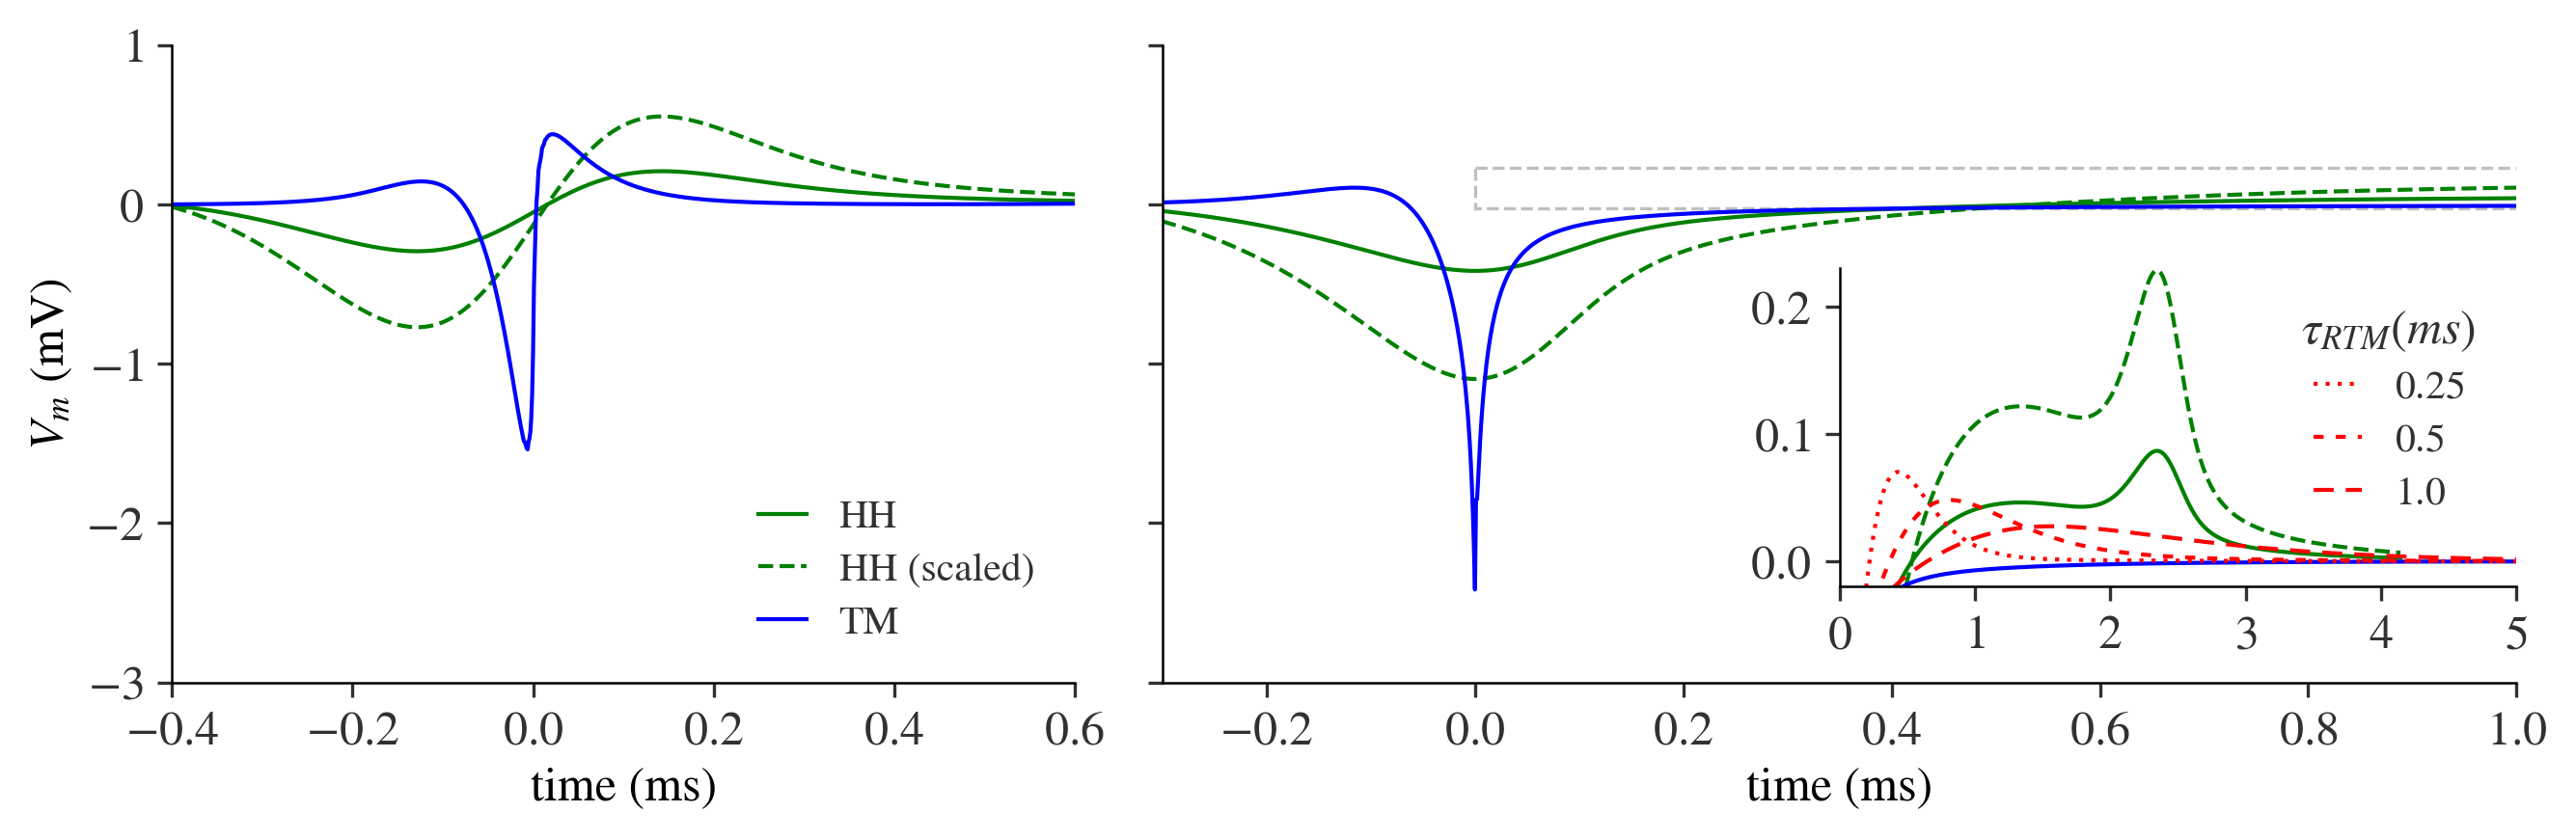

In [72]:
with plt.style.context('plot_style.txt'):
    fig, axs = plt.subplots(1,2, sharey=True, figsize=(9,3), gridspec_kw={'width_ratios':(2,3)})
    ax_slow = axs[1].inset_axes([0.5, 0.15, 0.5, 0.5])

    def plt_purkinje(result_file, scale=False, **kwargs):
        result = pel.get_result(datapath+result_file, downsampling_factor=1)

        vext_max = result['v_ext_v'].min(1)
        prop_peak = vext_max[0]#len(vext_max)//4]
        scaling_f = -1.1*mV/prop_peak

        source_n = result['source_v'].shape[0]
        ix_min = result['target_v'].min(1).argmin()

        t, v = result['target_t'], result['target_v']#*scaling_f
        if scale:
            v = v*scaling_f
        # Plot target impact by propagaging AP
        v_propagating = v[ix_min//3,:]
        t_0_propagating = t[v_propagating.argmin()]
        t_0_propagating = t[np.diff(v_propagating).argmax()]
        # Plot target impact by annihilating AP
        v_annihilating = v[ix_min,:]
        t_0_annihilating = t[v_annihilating.argmin()]
        print(f'{kwargs["label"]:30s}: scaling factor = {scaling_f:1.2f}',
              '  v_max=', v_annihilating.max().in_unit(br.mvolt, 3))
        if not '.' in kwargs['label']:
            axs[1].plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
            axs[0].plot((t-t_0_propagating)/ms, v_propagating/mV, **kwargs)
            kwargs.pop('label')
            ax_slow.plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)
        else:
            ax_slow.plot((t-t_0_annihilating)/ms, v_annihilating/mV, **kwargs)

    pre_lbl = 'less-'
    #plt_purkinje(pre_lbl+'purkinje-tm.h5'    , color='navy', ls='-', label='TM (g)')
    
    #plt_purkinje(pre_lbl+'purkinje-rtm450-s.h5', color='red', ls='-', label=r'RTM $\tau_r = 2$ms')
    
    plt_purkinje(pre_lbl+'purkinje-hh.h5'     , color='green', ls='-', label='HH')
    plt_purkinje(pre_lbl+'purkinje-hh.h5'     , scale=True, color='green', ls='--', label='HH (scaled)')
    plt_purkinje(pre_lbl+'purkinje-tm450.h5'  , color='blue', ls='-', label='TM') 
    plt_purkinje(pre_lbl+'purkinje-rtm450-ff.h5', color='red', ls=(0, (1, 2)), label=r'$0.25$')
    plt_purkinje(pre_lbl+'purkinje-rtm450-f.h5', color='red', ls=(0, (2.5, 3)), label=r'$0.5$')
    plt_purkinje(pre_lbl+'purkinje-rtm450.h5'  , color='red', ls=(0, (5, 3)), label=r'$1.0$')

    ax_slow.set_xlim(0.0,5.0)
    ax_slow.set_ylim(-.02,0.23)
    axs[1].add_patch(plt.Rectangle(xy=(ax_slow.get_xlim()[0], ax_slow.get_ylim()[1]),
                                   width=ax_slow.get_xlim()[1]-ax_slow.get_xlim()[0],
                                   height=-ax_slow.get_ylim()[1]+ax_slow.get_ylim()[0],
                                   fill=False, linestyle="--", alpha=0.5, color="grey"))

    #axs[0].set_xlim(-1.0, 4)
    axs[0].set_xlim(-0.4, 0.6)
    #axs[1].set_xlim(-1.0, 3)
    axs[1].set_xlim(-0.3, 1.0)
    axs[1].set_xlabel('time (ms)')
    axs[0].legend(loc='lower right')
    ax_slow.legend(loc='upper right', title=r'$\tau_{RTM} (ms)$')
    axs[0].set_xlabel('time (ms)')
    axs[0].set_ylabel('$V_m$ (mV)')
    plt.tight_layout()
    fig.savefig('../gfx/purkinje-less.pdf', bbox_inches='tight')
    

In [4]:
case = '2k-o'
result_hh = pel.get_result(Path(data_path, '1um_'+case+'hh.h5'))
print('hh')
result_tm = pel.get_result(Path(data_path, '1um_'+case+'tm.h5'))
print('tm')
result_rtm = pel.get_result(Path(data_path, '1um_'+case+'rtm-0.50.h5'))
print('rtm')

hh
tm
rtm


In [5]:
case = '2k--'
result_s_hh = pel.get_result(Path(data_path, '1um_'+case+'hh.h5'))
print('hh')
result_s_tm = pel.get_result(Path(data_path, '1um_'+case+'tm.h5'))
print('tm')
result_s_rtm = pel.get_result(Path(data_path, '1um_'+case+'rtm-0.50.h5'))
print('rtm')
#result_tm = pel.get_result(Path(data_path, '1um_'+case+'tm.h5'))
# ['1um_2k--hh.h5',
#  '1um_2k--rtm-0.25.h5',
#  '1um_2k--rtm-0.50.h5',
#  '1um_2k--rtm-1.00.h5',
#  '1um_2k--tm.h5',
#  '1um_2k-ohh.h5',
#  '1um_2k-ortm-0.25.h5',
#  '1um_2k-ortm-0.50.h5',
#  '1um_2k-ortm-1.00.h5',
#  '1um_2k-otm.h5']

hh
tm
rtm


In [8]:
allkeys = result_rtm['source_params'].keys()
for model in [result_rtm]:
    thiskeys = model['source_params'].keys()
    for k in thiskeys:
        print('%20s'%k, model['source_params'][k])

               gstar 450. m^-4 kg^-1 s^3 A^2
    repol_exponent_v 4
    repol_exponent_g 4
              trelax 0.5 ms
                  gL 4.5 m^-4 kg^-1 s^3 A^2
                  Cm 0.01 m^-4 kg^-1 s^4 A^2
                  Ri 1. m^3 kg s^-3 A^-2


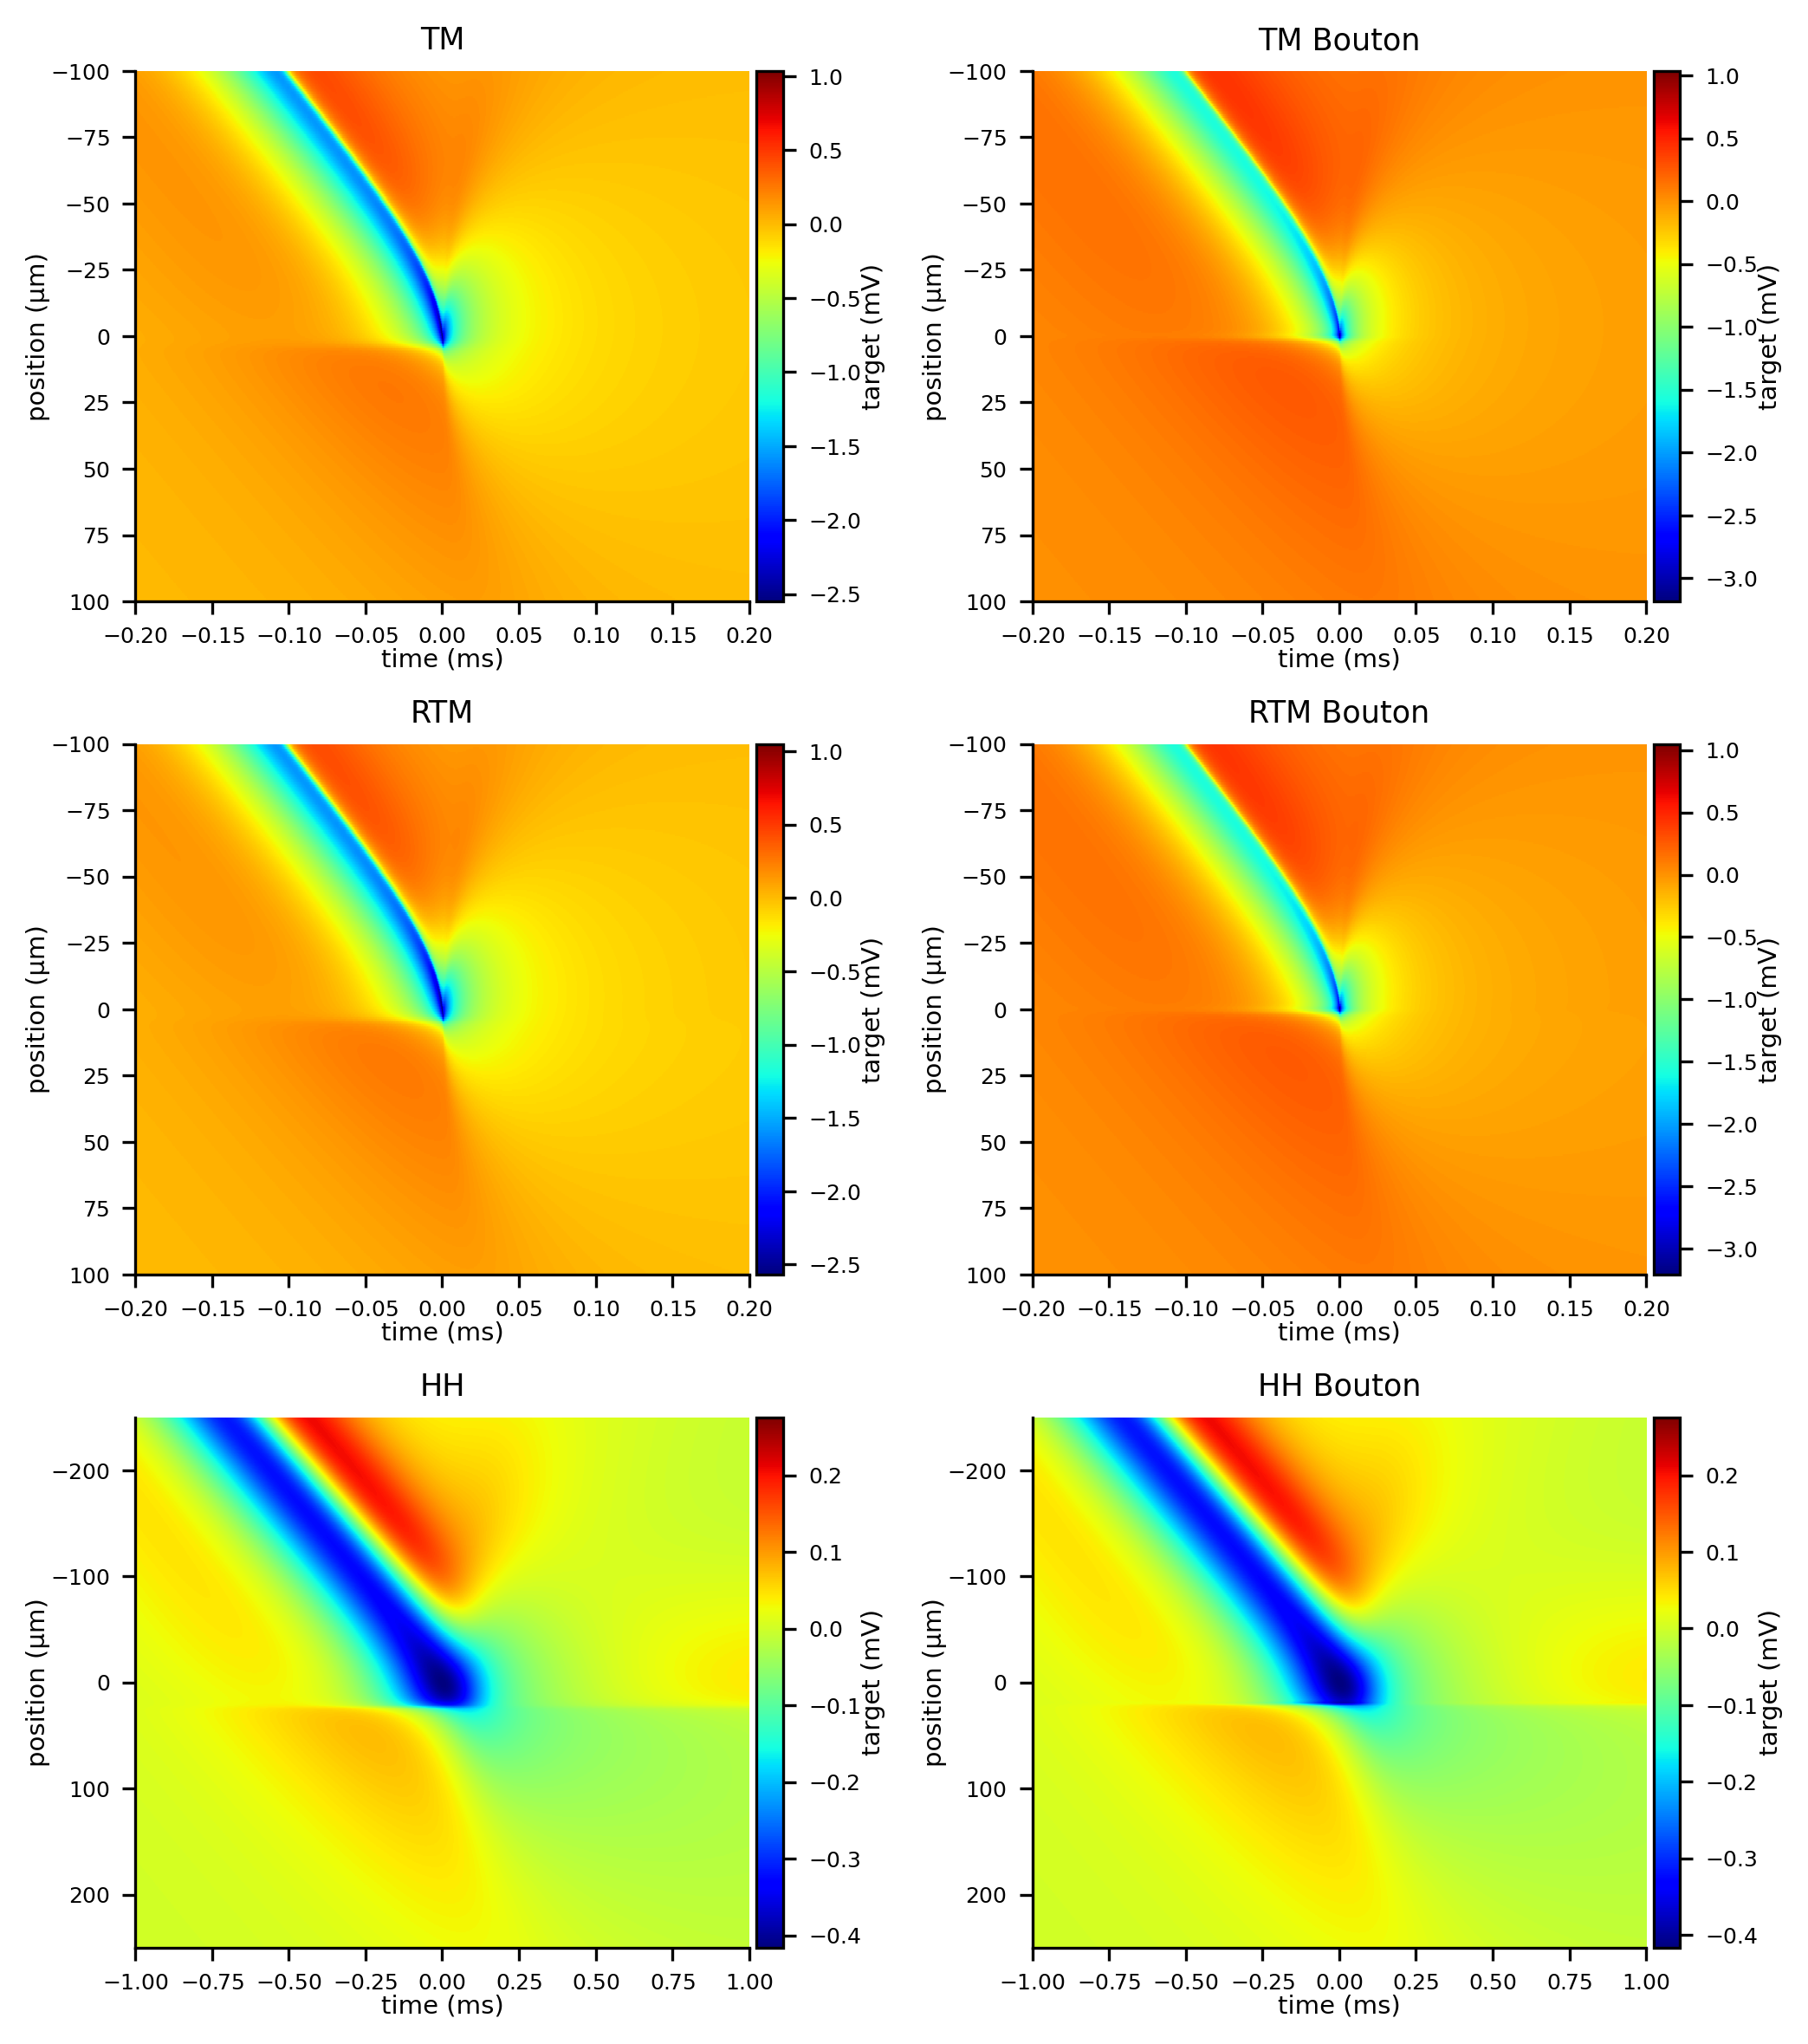

In [9]:
def putimg(title, result, ax, dt=0.6, dy=100, clbl='target (mV)', **kwargs):
    ax.set_title(title)
    v = result['target_v']/br.mV
    ix, it = np.unravel_index(np.argmin(v, axis=None), v.shape)
    #ix, it = find_dist_depol(result)
    t0 = result['target_t'][it]/br.ms
    x0 = result['target_x'][ix]/br.um
    #t0=0
    #x0=0
    im0 = ax.imshow(v,
                    extent=[(result['target_t'][0])/br.ms -t0,
                            (result['target_t'][-1])/br.ms -t0,
                            (result['target_x'][-1])/br.um -x0,
                            (result['target_x'][0])/br.um -x0,
                           ],
                    aspect='auto',
                    interpolation='none',
                    #vmin=-10,
                    cmap='jet',#'nipy_spectral',
                    **kwargs
                   )
    
    #ax.axhline(result['target_x'][ix]/br.um - x0, ls = '--')
    #ax.axvline(result['target_t'][it]/br.ms - t0, ls = '--')
    ax.set_xlim(-dt, +dt)
    ax.set_ylim(dy, -dy)
    ax.set_ylabel("position (µm)")
    ax.set_xlabel("time (ms)")
    
    fig.colorbar(im0, ax=ax, pad=0.01, label=clbl)
    

with plt.style.context('plot_style.txt'):
    cm = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(3,2, figsize=(17.8*cm, 20*cm))#, sharey=True, sharex='col')
    # fig, axs = plt.subplots(3,2, figsize=(8,10))
    putimg('TM', result_s_tm, axs[0,0], dt=0.2)# label=r'$1.0$')
    putimg('RTM', result_s_rtm, axs[1,0], dt=0.2)# label=r'$1.0$')
    putimg('HH', result_s_hh, axs[2,0], dt=1, dy=250)# label=r'$1.0$')

    putimg('TM Bouton', result_tm, axs[0,1], dt=0.2)# label=r'$1.0$')
    putimg('RTM Bouton', result_rtm, axs[1,1], dt=0.2)# label=r'$1.0$')
    putimg('HH Bouton', result_hh, axs[2,1], dt=1, dy=250)# label=r'$1.0$')

    plt.tight_layout()
    plt.savefig("SI-purkinje.pdf")
    plt.show()